In [2]:
#生成测试数据
import pandas as pd
import random
from datetime import datetime, timedelta

# 创建一个随机日期生成器
def random_date(start, end):
    return start + timedelta(
        seconds=random.randint(0, int((end - start).total_seconds()))
    )

# 定义随机数据范围
start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 11, 21)
users = [f"user_{i}" for i in range(1, 11)]
resource_types = ["Server", "Database", "Switch", "Router"]
ips = [f"192.168.{i}.{j}" for i in range(1, 5) for j in range(1, 255)]
protocols = ["SSH", "RDP", "Telnet", "HTTP"]
commands = [
    "ls -la",
    "rm -rf /tmp/*",
    "systemctl restart apache2",
    "cat /etc/passwd",
    "sudo apt update",
    "scp file.txt user@192.168.1.100:/home/",
    "exit",
]

# 生成数据
data = []
for i in range(1000):
    data.append({
        "编号": i + 1,
        "时间": random_date(start_date, end_date).strftime("%Y-%m-%d %H:%M:%S"),
        "用户": random.choice(users),
        "资源类型": random.choice(resource_types),
        "资源IP": random.choice(ips),
        "资源账号": random.choice(users),
        "登录协议": random.choice(protocols),
        "操作命令列表": ", ".join(random.sample(commands, random.randint(1, 5))),
    })

   

# 创建DataFrame
df = pd.DataFrame(data)

# 保存为CSV文件
file_path = "data/bastion_logs.csv"
df.to_csv(file_path, index=False)

file_path


'data/bastion_logs.csv'

In [2]:
#数据清洗
import pandas as pd

# 加载数据
file_path = "data/bastion_logs.csv"
df = pd.read_csv(file_path)

# 显示原始数据的记录数
original_count = len(df)

# 删除没有操作命令、没有资源IP、没有用户的数据
df_cleaned = df.dropna(subset=['操作命令列表', '资源IP', '用户'])

# 显示清洗后的数据的记录数
cleaned_count = len(df_cleaned)

# 保存清洗后的数据
cleaned_file_path = "data/bastion_logs_cleaned.csv"
df_cleaned.to_csv(cleaned_file_path, index=False)

original_count, cleaned_count, cleaned_file_path


(1000, 1000, 'data/bastion_logs_cleaned.csv')

In [4]:
#热编码
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# 加载清洗后的数据
cleaned_file_path = "data/bastion_logs_cleaned.csv"
df = pd.read_csv(cleaned_file_path)

# 1. 时间戳转换
df['时间'] = pd.to_datetime(df['时间'])
df['时间戳'] = df['时间'].astype(int) / 10**9  # 转换为秒级时间戳

# 2. 类别字段编码
encoder = OneHotEncoder(sparse_output=False, handle_unknown='error')  # 更新参数名
encoded_columns = ['用户', '资源类型', '资源IP', '登录协议']

# 对类别字段进行OneHotEncoding
encoded_features = encoder.fit_transform(df[encoded_columns])
encoded_features_df = pd.DataFrame(
    encoded_features, columns=encoder.get_feature_names_out(encoded_columns)
)

# 打印编码后的结果，验证输出
print(encoded_features_df.head(10))

# 3. 合并数值特征
df_final = pd.concat([df[['编号', '时间戳']], encoded_features_df], axis=1)

# 保存编码后的数据
encoded_file_path = "data/bastion_logs_encoded.csv"
df_final.to_csv(encoded_file_path, index=False)

print(f"编码完成！文件已保存为 {encoded_file_path}")


   用户_user_1  用户_user_10  用户_user_2  用户_user_3  用户_user_4  用户_user_5  \
0        1.0         0.0        0.0        0.0        0.0        0.0   
1        0.0         0.0        0.0        0.0        1.0        0.0   
2        0.0         0.0        0.0        0.0        0.0        0.0   
3        0.0         0.0        0.0        0.0        0.0        0.0   
4        0.0         0.0        0.0        0.0        1.0        0.0   
5        0.0         0.0        0.0        0.0        0.0        1.0   
6        0.0         0.0        0.0        1.0        0.0        0.0   
7        0.0         0.0        0.0        0.0        0.0        0.0   
8        0.0         0.0        0.0        0.0        1.0        0.0   
9        0.0         0.0        0.0        0.0        0.0        0.0   

   用户_user_6  用户_user_7  用户_user_8  用户_user_9  ...  资源IP_192.168.4.9  \
0        0.0        0.0        0.0        0.0  ...               0.0   
1        0.0        0.0        0.0        0.0  ...             

In [1]:
#异常检测
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
import pandas as pd

# 1. 加载数据
encoded_file_path = "data/bastion_logs_encoded.csv"
df_encoded = pd.read_csv(encoded_file_path)

# 提取特征
features = df_encoded.drop(columns=['编号'])  # 移除非特征列

# 2. 数据分割
train_data, test_data = train_test_split(features, test_size=0.2, random_state=42)

# 3. 获取训练时的特征名
train_features = train_data.columns

# 4. 构建Isolation Forest模型
model = IsolationForest(n_estimators=150, contamination=0.1, random_state=42)
model.fit(train_data)

# 5. 确保测试数据特征与训练数据一致
test_features = test_data[train_features]  # 使用训练时的特征名过滤测试数据

# 6. 预测异常值
test_data['anomaly_score'] = model.decision_function(test_features)
test_data['anomaly'] = model.predict(test_features)

# 转换异常标记：-1 表示异常，1 表示正常
test_data['anomaly'] = test_data['anomaly'].apply(lambda x: 'Anomalous' if x == -1 else 'Normal')

# 7. 统计异常比例
anomaly_counts = test_data['anomaly'].value_counts()
print(f"调整后异常检测结果：\n{anomaly_counts}")

# 保存异常结果
anomalous_logs = test_data[test_data['anomaly'] == 'Anomalous']
anomalous_logs_file_path = "data/anomalous_logs.csv"
anomalous_logs.to_csv(anomalous_logs_file_path, index=False)

print(f"异常日志已保存到 {anomalous_logs_file_path}")






调整后异常检测结果：
anomaly
Normal       193
Anomalous      7
Name: count, dtype: int64
异常日志已保存到 data/anomalous_logs.csv


In [16]:
# 按资源类型分组统计异常日志
anomalous_logs = pd.read_csv(anomalous_logs_file_path)
grouped = anomalous_logs.groupby('资源类型').size().reset_index(name='异常数量')

print("按资源类型统计异常日志：")
print(grouped)

# 保存分组统计结果
grouped_file_path = "data/anomalous_logs_grouped.csv"
grouped.to_csv(grouped_file_path, index=False)
print(f"分组统计结果已保存到 {grouped_file_path}")


KeyError: '资源类型'

In [11]:
#生成合规性报告
# 按时间分布统计异常和正常日志
test_data['时间'] = pd.to_datetime(test_data['时间戳'], unit='s')
time_distribution = test_data.groupby(['时间', 'anomaly']).size().unstack(fill_value=0)

# 保存合规性报告
report_file_path = "data/compliance_report.csv"
time_distribution.to_csv(report_file_path)
print(f"合规性报告已保存到 {report_file_path}")


合规性报告已保存到 data/compliance_report.csv


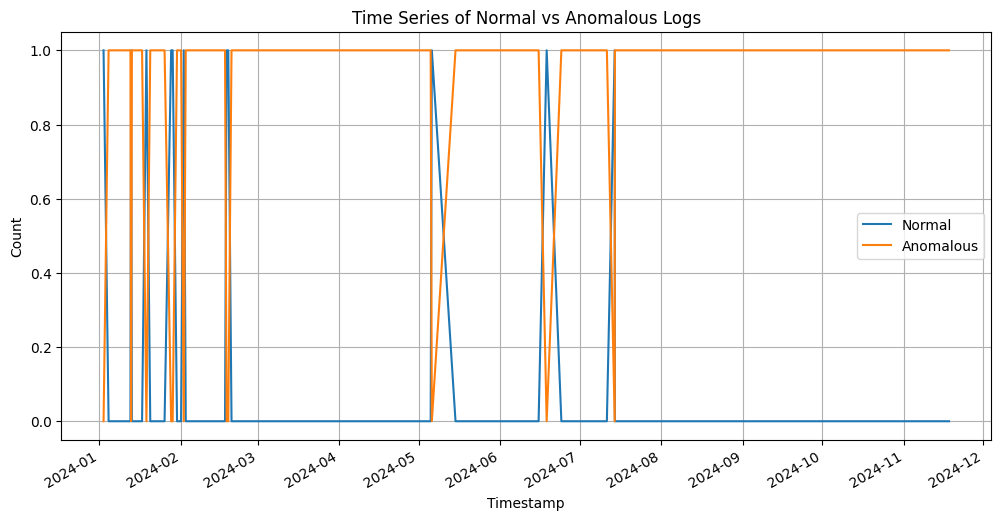

In [12]:
#异常日志可视化
import matplotlib.pyplot as plt

# 按时间绘制异常和正常日志分布
time_distribution.plot(kind='line', figsize=(12, 6))
plt.title('Time Series of Normal vs Anomalous Logs')
plt.xlabel('Timestamp')
plt.ylabel('Count')
plt.legend(['Normal', 'Anomalous'])
plt.grid()
plt.show()


In [13]:
# 调整异常比例参数
model = IsolationForest(n_estimators=150, contamination=0.1, random_state=42)
model.fit(train_data)

# 重新预测
test_features = test_data.drop(columns=['anomaly_score'], errors='ignore')
test_data['anomaly_score'] = model.decision_function(test_features)
test_data['anomaly'] = model.predict(test_features)

# 统计异常比例
anomaly_counts = test_data['anomaly'].value_counts()
print(f"调整后异常检测结果：\n{anomaly_counts}")


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- anomaly
- 时间
